## Regret Analysis of OFL - \<Performance Experiments\>

### 1. Environment Setting

In [19]:
import  torch
import  numpy as np
import  matplotlib.pyplot as plt
from    keras import datasets
import  import_ipynb

from RegretBound import opt_param
from data import CIFAR_10_data, MNIST_data, Air_data, Room_data, Cond_data, Tom_data, Energy_data
from model import OFL_Model
from utils import sigma_diff

K = 1000        # Number of clients
#D = 34826       # number of parameters (MNIST)
D = 52874       # CIFAR-10
# D = 4353        # (Air, Cond, Tom)
#D = 4548         # (Room)
P = 0.05        # Com. overhead reduction rate from FedOGD
L = 8           # Local training time (Batch Size)

s, _, b, p = opt_param(P, D, show_result=False)
p2 = p * L
print(s, b, p, p2)

9 1658 0.3004299983762661 2.403439987010129


### 2. Experiment Setting

In [20]:
#Clf -> MNIST, Room Occupancy
x_train, y_train, input_size = CIFAR_10_data() #MNIST_data() #Room_data()
task = 'clf'

#Reg -> Air, Conductivity
# x_train, y_train, input_size = Air_data() #Cond_data()
# task = 'reg'

#TOM, Energy
# x_train, y_train, input_size = Energy_data() #Tom_data()
# task = 'reg'

170508288/170498071 [==============================] - 20s 0us/step


In [21]:
Model_list = []

Model_list.append(OFL_Model('FedOGD', task, K, [False, 0, 0], 1, 1, input_size))
Model_list.append(OFL_Model('OFedAvg', task, K, [False, 0, 0], P, 1, input_size))
Model_list.append(OFL_Model('FedOMD', task, K, [False, 0, 0], 1, int(1/P), input_size))
Model_list.append(OFL_Model('OFedIQ', task, K, [True, s, b], p, 1, input_size))
#Model_list.append(OFL_Model('OFedIQ(L=8)', task, K, [True, s, b], p2, L, input_size))


### 3. Training

In [22]:
i_max = len(y_train) // K
iter_max = 25
print(iter_max, i_max)

#iter = 15,60 / 80,4 / 40, 9

25 50


In [23]:
for model in Model_list:
    for iter in range(iter_max):
        for i in range(i_max):
            model.train(x_train[K*i : K*(i+1)], y_train[K*i : K*(i+1)], ((i_max * iter) + (i+1)) % model.L)
        print(iter, end =',')
    print()

result_list = []
for model in Model_list:
    result_list.append(model.pull_result())

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,


In [25]:
import pickle

#Code: data / data_90
code = input("Code: ")

for i, model in enumerate(Model_list):
    name = model.name
    with open(f"./result/{task}_{name}_{code}.pkl","wb") as f:
        pickle.dump(result_list[i], f)

### 3. Save Result

### 4. Plot Result

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


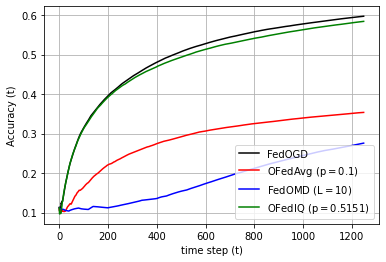

In [26]:
import pickle
import matplotlib.pyplot  as plt

code = input('Code:')

with open(f"./result/{task}_FedOGD_{code}.pkl", "rb") as f:
    r1 = pickle.load(f)
with open(f"./result/{task}_OFedAvg_{code}.pkl", "rb") as f:
    r2 = pickle.load(f)
with open(f"./result/{task}_FedOMD_{code}.pkl", "rb") as f:
    r3 = pickle.load(f)
with open(f"./result/{task}_OFedIQ_{code}.pkl", "rb") as f:
    r4 = pickle.load(f)

l1 = list(range(len(r1))) 
l2 = list(range(len(r2)))
l3 = list(range(len(r3)))
l4 = list(range(len(r4)))

plt.plot(l1, r1, 'black', label=r'FedOGD')
plt.plot(l2, r2, 'red', label=r'OFedAvg ($\mathdefault{p=0.1}$)')
plt.plot(l3, r3, 'blue', label=r'FedOMD ($\mathdefault{L=10}$)')
plt.plot(l4, r4, 'green', label=r'OFedIQ ($\mathdefault{p=0.5151}$)')

plt.xlabel('time step (t)')

if task == 'clf':
    plt.ylabel('Accuracy (t)')
elif task == 'reg':
    plt.ylabel('MSE (t)')
    #plt.yscale("log")

plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.legend()

plt.savefig(f'./Figures/{task}_{code}.png', dpi=200, facecolor="white")
plt.show()


### 5. $\sigma_{\rm diff}$

In [16]:
x_train, y_train = MNIST_data()
sigma = sigma_diff(Model_list[0], x_train, y_train, 60)
print(sigma)

12.626342124166777


FedOGD w/ iid data: 7.069452932191554

FedOGD w/ non-iid data: 12.626342124166777